In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import torch

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

In [2]:
dataset = 'coco2017'
annot_dir = './coco2017/annotations'
imgs_dir = './coco2017/{}2017'

for split in ['train', 'val']: 
    #if split == 'train':
        #annot_path = 'cityscapes/annotations/instancesonly_filtered_gtFine_train_temp.json'
    #else:
    annot_path = os.path.join(annot_dir, f'instances_{split}2017.json')
    d_name = dataset + f'_{split}'
    register_coco_instances(d_name, {}, annot_path, imgs_dir.format(split))

# Load dataset
dataset_dicts = DatasetCatalog.get('coco2017_val')
metadata = MetadataCatalog.get('coco2017_val')

[04/16 23:15:57 d2.data.datasets.coco]: Loaded 5000 images in COCO format from ./coco2017/annotations/instances_val2017.json


./coco2017/val2017/000000534673.jpg
(480, 640, 3)
./coco2017/val2017/000000308587.jpg
(640, 480, 3)
./coco2017/val2017/000000164363.jpg
(604, 640, 3)


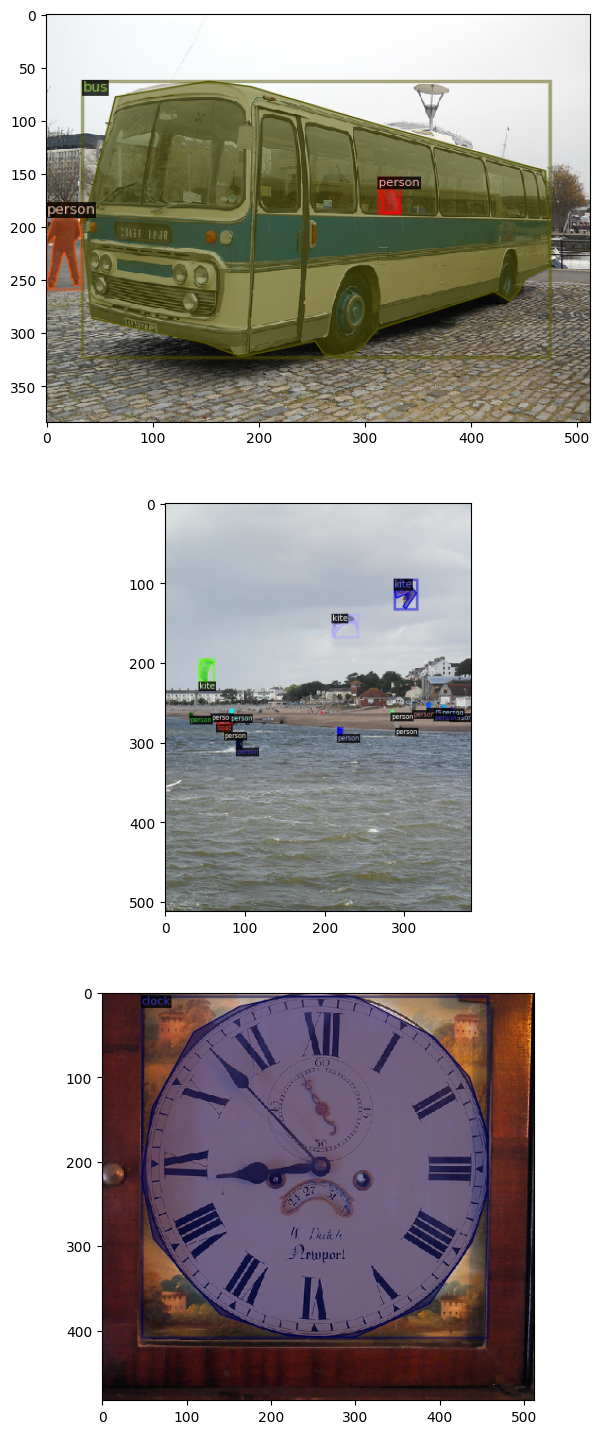

In [3]:
# Visualize random images with ground truth annotations
num_images_to_visualize = 3  # Adjust the number of images to visualize

_, axs = plt.subplots(nrows=num_images_to_visualize, figsize=(18, 18))

for i, d in enumerate(random.sample(dataset_dicts, num_images_to_visualize)):
    print(d["file_name"])

    im = cv2.imread(d["file_name"])

    print(im.shape)


    # Get ground truth annotations
    visualizer = Visualizer(im[:, :, ::-1], metadata=metadata, scale=0.8)
    vis = visualizer.draw_dataset_dict(d)

    # Plot the image with ground truth annotations
    axs[i].imshow(vis.get_image())

In [4]:
import argparse

class Args(argparse.Namespace):
    config_file='khang_net/configs/huflit_net/huflit_net_se_1x.py'
    eval_only=False
    num_gpus=1
    num_machines=1
    resume=False

args = Args()

In [5]:
from detectron2.model_zoo import get_config
from detectron2.config import LazyConfig
from detectron2.config.instantiate import instantiate


cfg = LazyConfig.load("khang_net/configs/huflit_net/huflit_net_se_1x.py")
cfg.train.device = 'mps'
cfg.dataloader.evaluator.dataset_name = 'cityscapes_val'
cfg.dataloader.train.dataset.names = 'cityscapes_train'
cfg.dataloader.test.dataset.names = 'cityscapes_val'
cfg.dataloader.train.total_batch_size = 1

cfg.model.num_classes = 90
cfg.model.yolof.num_classes = 90
cfg.model.mask_head.num_classes = 90

In [6]:
huflit_net = instantiate(cfg.model)

In [7]:
from detectron2.checkpoint import DetectionCheckpointer

huflit_net.train(False)
DetectionCheckpointer(huflit_net).load('/Users/giakhang/Downloads/output/model_0000999.pth')

[04/16 23:15:58 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /Users/giakhang/Downloads/output/model_0000999.pth ...


AssertionError: Checkpoint /Users/giakhang/Downloads/output/model_0000999.pth not found!

In [8]:
huflit_net.to('mps')

HUFLIT_Net(
  (yolof): YOLOF(
    (backbone): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): SEBlock(
          (shortcut): Conv2d(
            64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
            (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
          )
          (conv1): Conv2d(
            64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
            (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
          )
          (conv2): Conv2d(
            64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
            (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
          )
          (conv3): Conv2d(
            64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
            (norm): FrozenBatchNorm2d(num_features=256, eps

In [8]:
dataloader = instantiate(cfg.dataloader.train)
# show image
batch = next(iter(dataloader))

[03/23 16:40:13 d2.data.datasets.coco]: Loaded 1 images in COCO format from cityscapes/annotations/instancesonly_filtered_gtFine_train_temp.json
[03/23 16:40:13 d2.data.build]: Removed 0 images with no usable annotations. 1 images left.
[03/23 16:40:13 d2.data.build]: Distribution of instances among all 8 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   person   | 14           |    car     | 9            |   truck    | 0            |
|   rider    | 0            | motorcycle | 0            |  bicycle   | 4            |
|    bus     | 2            |   train    | 0            |            |              |
|   total    | 29           |            |              |            |              |
[03/23 16:40:13 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=[800], max_size=1333, sample_style='ch

In [ ]:
results = huflit_net(batch)

/Users/giakhang/miniconda3/envs/hope_to_public_net/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025539291/work/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
output = results[0]
pred_boxes = output['instances'].pred_boxes[:4].tensor.to('cpu').detach().to(torch.int32).numpy()
pred_classes = output['instances'].pred_classes[:4].to('cpu').detach().to(torch.int32).numpy()
pred_masks = output['instances'].pred_masks[:4].to('cpu').numpy()

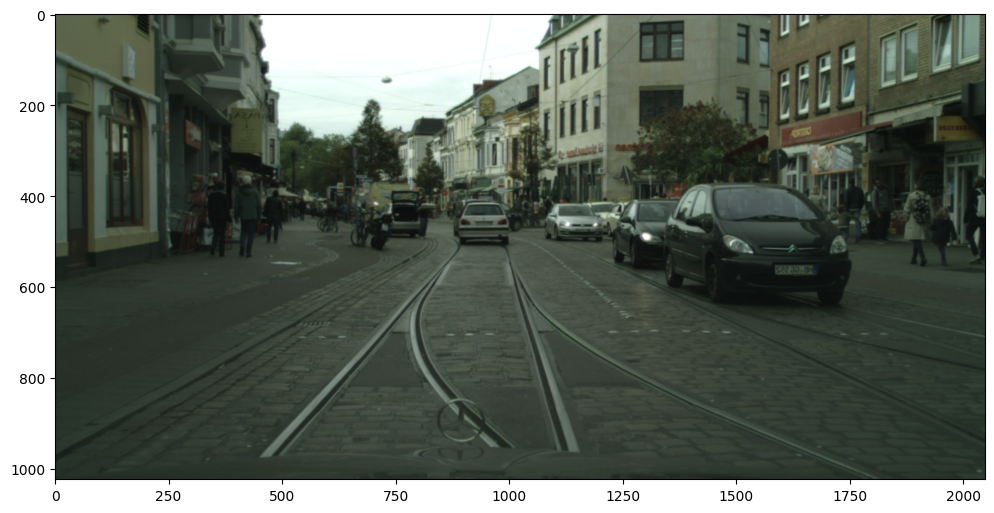

In [15]:
img = batch[0]['image'].permute(1, 2, 0).numpy()
img = np.ascontiguousarray(img)

h_w = output['instances'].image_size
img = cv2.resize(img, h_w[::-1])

_ = plt.figure(figsize=(12, 10))
plt.imshow(img[..., ::-1])

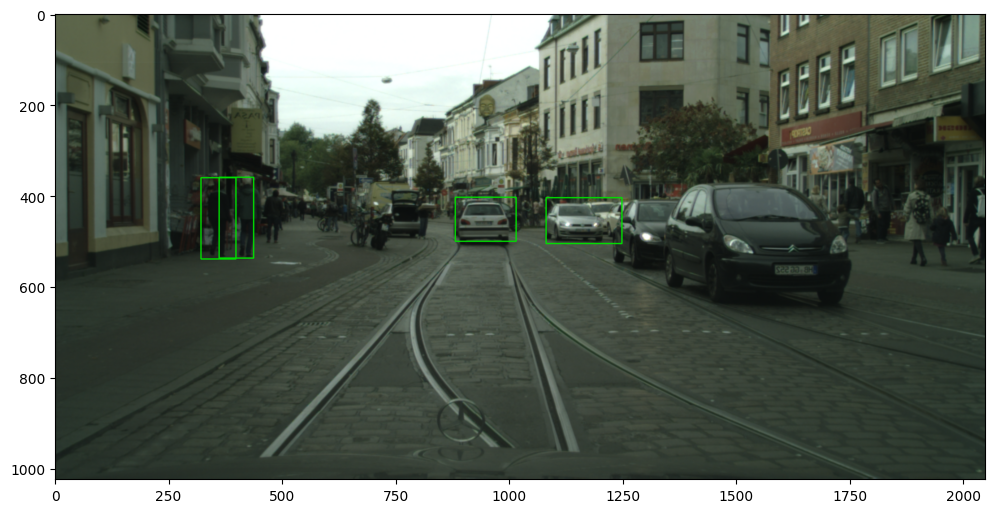

In [16]:
img_draw = img.copy()

for box in pred_boxes:
    img_draw = cv2.rectangle(img_draw, box[:2], box[2:], (0, 225, 0), 2)
    #print(box[:2], box[2:])

_ = plt.figure(figsize=(12, 10))
plt.imshow(img_draw[..., ::-1])

In [17]:
mask = np.zeros(pred_masks.shape[1:])

for i in range(pred_masks.shape[0]):
    mask = np.logical_or(mask, pred_masks[i])

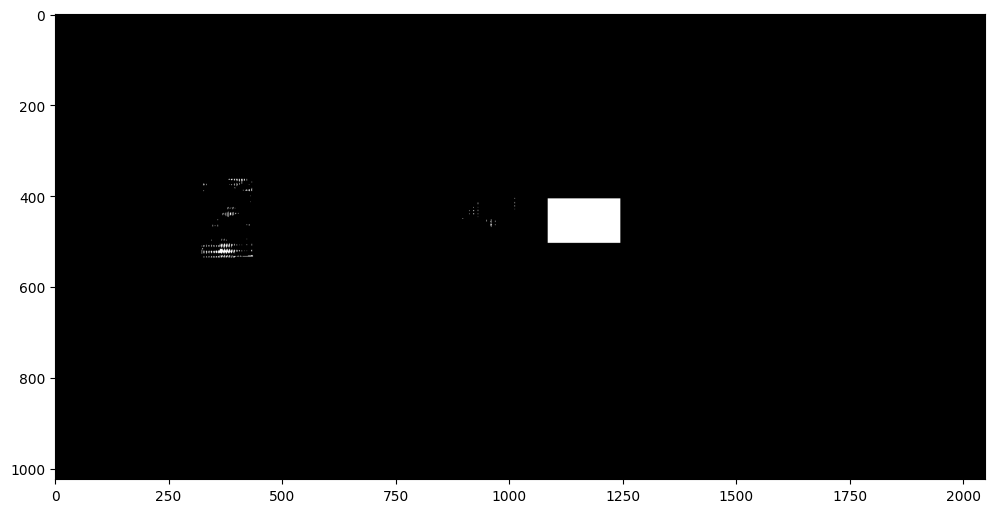

In [18]:
_ = plt.figure(figsize=(12, 10))
plt.imshow(mask, cmap='gray')